# CTA 2D source fitting with Sherpa
F. Acero & Y. Gallant
October 2017

## Introduction

Sherpa is the X-ray satellite Chandra modeling and fitting application. It enables the user to construct complex models from simple definitions and fit those models to data, using a variety of statistics and optimization methods. 
The issues of constraining the source position and morphology are common in X- and Gamma-ray astronomy. 
This notebook will show you how to apply Sherpa to CTA data.

Here we will set up Sherpa to fit the counts map and loading the ancillary images for subsequent use. A relevant test statistic for data with Poisson fluctuations is the one proposed by Cash (1979). The simplex (or Nelder-Mead) fitting algorithm is a good compromise between efficiency and robustness. The source fit is best performed in pixel coordinates.

## Read sky images
The sky image that are loaded here have been prepared in a separated notebook. Here we start from those fits file and focus on the source fitting aspect.

The info needed for sherpa are:
- Count map
- Background map
- Exposure map
- PSF map

For info, the fits file are written in the following way in the Sky map generation notebook:

```
images['counts']    .write("G300-0_test_counts.fits", clobber=True)
images['exposure']  .write("G300-0_test_exposure.fits", clobber=True)
images['background'].write("G300-0_test_background.fits", clobber=True)

##As psf is an array of quantities we cannot use the images['psf'].write() function
##all the other arrays do not have quantities. 
fits.writeto("G300-0_test_psf.fits",images['psf'].data.value,overwrite=True)
```


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from gammapy.image import SkyImage
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS

# You may see a Warning concerning XSPEC
# As we will note use Xspec spectral models this warning is not important
import sherpa.astro.ui as sh

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


In [2]:
# Read the fits file to load them in a sherpa model
hdr = fits.getheader("G300-0_test_counts.fits")
wcs = WCS(hdr)

sh.set_stat("cash")
sh.set_method("simplex")
sh.load_image("G300-0_test_counts.fits")
sh.set_coord("logical")

sh.load_table_model("expo", "G300-0_test_exposure.fits")
sh.load_table_model("bkg", "G300-0_test_background.fits")
sh.load_psf("psf", "G300-0_test_psf.fits")

In principle one might first want to fit the background amplitude. However the background estimation method already yields the correct normalization, so we freeze the background amplitude to unity instead of adjusting it. The (smoothed) residuals from this background model are then computed and shown.

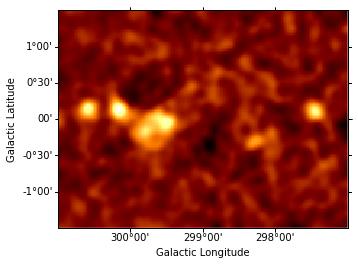

In [3]:
sh.set_full_model(bkg)
bkg.ampl = 1
sh.freeze(bkg)

data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=wcs)

resid_table = []  # Keep residual images in a list to show them later
resid_smo6 = resid.smooth(radius = 6)
resid_smo6.plot()
resid_table.append(resid_smo6)

### Find and fit the brightest source
We then find the position of the maximum in the (smoothed) residuals map, and fit a (symmetrical) Gaussian source with that initial position:

In [4]:
maxcoord = resid_smo6.lookup_max()
maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])
sh.set_full_model(bkg + psf(sh.gauss2d.g0) * expo) # creates g0 as a gauss2d instance
g0.xpos = maxpix[0]
g0.ypos = maxpix[1]
sh.freeze(g0.xpos, g0.ypos) # fix the position in the initial fitting step

expo.ampl = 1e-9 # fix exposure amplitude so that typical exposure is of order unity
sh.freeze(expo)
sh.thaw(g0.fwhm, g0.ampl) # in case frozen in a previous iteration

g0.fwhm = 10 # give some reasonable initial values
g0.ampl = maxcoord[1]
sh.fit() # Performs the fit; this takes a little time.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47907.2
Final fit statistic   = 47503 at function evaluation 234
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 404.211
   g0.fwhm        6.43418     
   g0.ampl        0.400131    


Fit all parameters of this Gaussian component, fix them and re-compute the residuals map.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47503
Final fit statistic   = 47498.4 at function evaluation 354
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 4.57486
   g0.fwhm        6.33581     
   g0.xpos        41.9218     
   g0.ypos        81.3048     
   g0.ampl        0.417545    


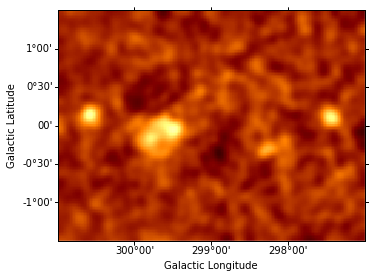

In [5]:
sh.thaw(g0.xpos, g0.ypos)
sh.fit()
sh.freeze(g0)

data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=wcs)

resid_smo6 = resid.smooth(radius = 6)
resid_smo6.show(vmin = -0.5, vmax = 1)
resid_table.append(resid_smo6)

### Iteratively find and fit additional sources
Instantiate additional Gaussian components, and use them to iteratively fit sources, repeating the steps performed above for component g0. (The residuals map is shown after each additional source included in the model.) This takes some time...

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47498.4
Final fit statistic   = 47335 at function evaluation 269
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 163.402
   g1.fwhm        19.8613     
   g1.ampl        0.100529    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47335
Final fit statistic   = 47293.7 at function evaluation 394
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 41.3431
   g1.fwhm        19.9265     
   g1.xpos        67.2544     
   g1.ypos        69.3013     
   g1.ampl        0.116012    


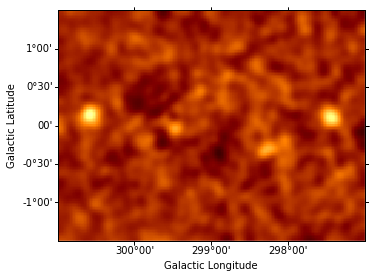

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47293.7
Final fit statistic   = 47185.5 at function evaluation 264
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 108.124
   g2.fwhm        6.20212     
   g2.ampl        0.393345    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47185.5
Final fit statistic   = 47182.5 at function evaluation 342
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 3.05173
   g2.fwhm        6.19309     
   g2.xpos        20.8274     
   g2.ypos        81.6413     
   g2.ampl        0.40001     


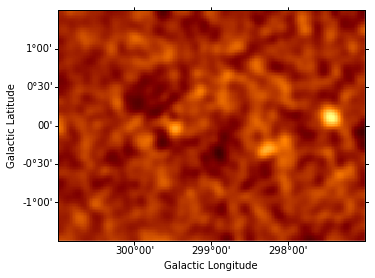

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47182.5
Final fit statistic   = 47115 at function evaluation 275
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 67.4731
   g3.fwhm        6.43218     
   g3.ampl        0.235481    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47115
Final fit statistic   = 47114.3 at function evaluation 303
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 0.728928
   g3.fwhm        6.38175     
   g3.xpos        177.458     
   g3.ypos        80.2233     
   g3.ampl        0.239637    


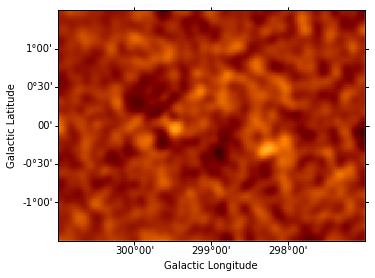

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47114.3
Final fit statistic   = 47086.6 at function evaluation 277
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 27.7341
   g4.fwhm        5.70151     
   g4.ampl        0.162191    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47086.6
Final fit statistic   = 47085.7 at function evaluation 304
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 0.898776
   g4.fwhm        5.94179     
   g4.xpos        135.942     
   g4.ypos        59.5875     
   g4.ampl        0.156213    


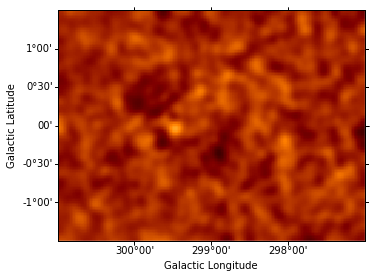

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47085.7
Final fit statistic   = 47069 at function evaluation 262
Data points           = 30000
Degrees of freedom    = 29998
Change in statistic   = 16.6424
   g5.fwhm        2.82885     
   g5.ampl        0.52359     
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 47069
Final fit statistic   = 47068.9 at function evaluation 328
Data points           = 30000
Degrees of freedom    = 29996
Change in statistic   = 0.0749129
   g5.fwhm        2.82317     
   g5.xpos        76.1381     
   g5.ypos        73.1869     
   g5.ampl        0.524268    


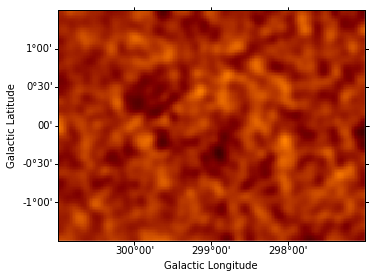

In [6]:
for i in range(1,6):
    sh.create_model_component('gauss2d', 'g' + str(i))

gs = [g0, g1, g2, g3, g4, g5]
sh.set_full_model(bkg + psf(g0+g1+g2+g3+g4+g5) * expo)

for i in range(1, len(gs)) :
    gs[i].ampl = 0   # initialize components with fixed, zero amplitude
    sh.freeze(gs[i])

for i in range(1, len(gs)) :
    maxcoord = resid_smo6.lookup_max()
    maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])
    gs[i].xpos = maxpix[0]
    gs[i].ypos = maxpix[1]
    gs[i].fwhm = 10
    gs[i].fwhm = maxcoord[1]

    sh.thaw(gs[i].fwhm)
    sh.thaw(gs[i].ampl)
    sh.fit()

    sh.thaw(gs[i].xpos)
    sh.thaw(gs[i].ypos)
    sh.fit()
    sh.freeze(gs[i])

    data = sh.get_data_image().y -  sh.get_model_image().y # estimate residual map = data - model
    resid = SkyImage(data=data, wcs=wcs)

    resid_smo6 = resid.smooth(radius = 6)
    resid_smo6.show(vmin = -0.5, vmax = 1)
    resid_table.append(resid_smo6)

### Generating output table and Test Statistics estimation
When adding a new source, one need to check the significance of this new source. A frequently used method is the Test Statistics (TS). This is done by comparing the change of statistics when the source is included compared to the null hypothesis (no source ; in practice here we fix the amplitude to zero).

$TS = Cstat(source) - Cstat(no source)$

The criterion for a significant source detection is typically that it should improve the test statistic by at least 25 or 30. The last excess fitted (g5) thus not a significant source:

In [7]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import Table

rows = []
for idx, g in enumerate(gs):
    ampl = g.ampl.val
    g.ampl = 0
    stati = sh.get_stat_info()[0].statval
    g.ampl = ampl
    statf = sh.get_stat_info()[0].statval
    delstat = stati - statf
    
    coord = resid.wcs_pixel_to_skycoord(g.xpos.val, g.ypos.val)
    pix_scale = resid.wcs_pixel_scale()[0].deg
    sigma = g.fwhm.val * pix_scale * gaussian_fwhm_to_sigma
    rows.append(dict(
        idx=idx,
        delstat=delstat,
        glon=coord.l.deg,
        glat=coord.b.deg,
        sigma=sigma ,
    ))

table = Table(rows=rows, names=rows[0])
table[table['delstat'] > 25]

idx,delstat,glon,glat,sigma
int64,float64,float64,float64,float64
0,136.582187364,300.151408614,0.136068174452,0.0538113987742
1,158.744570772,299.644884821,-0.103966965279,0.169240266293
2,111.176173057,300.57305638,0.142771893381,0.0525992264273
3,68.2020558775,297.441233657,0.114422638212,0.0542015591058
4,28.632872396,298.27120691,-0.298223927544,0.0504649169514


In [ ]:
# Small animation to show the source detection at each iteration
from ipywidgets.widgets.interaction import interact

def plot_resid(i):
    fig, ax,cbar = resid_table[i].plot(vmin=-0.5, vmax=1,cmap='CMRmap')
#    ax=plt.gca()
    ax.set_title('CStat=%.2f'%(table['delstat'][i]))
    ax.scatter(
    table['glon'][i], table['glat'][i],
    transform=ax.get_transform('galactic'),
    color='none', edgecolor='azure', marker='o', s=400)
#    plt.savefig('source_%i.png'%(i))
    plt.show()

interact(plot_resid,i=(0,5))

## Exercises

* If you look back to the original image: there's one source that looks like a shell-type supernova remnant.
    * Try to fit is with a shell morphology model (use ``sh.shell2d('shell')`` to create such a model).
    * Try to evaluate the ``TS`` and probability of the shell model compared to a Gaussian model hypothesis
    * You could also try a disk model (use ``sh.disk2d('disk')`` to create one)

## What next?

These are good resources to learn more about Sherpa:

* https://python4astronomers.github.io/fitting/fitting.html
* https://github.com/DougBurke/sherpa-standalone-notebooks

You could read over the examples there, and try to apply a similar analysis to this dataset here to practice.

If you want a deeper understanding of how Sherpa works, then these proceedings are good introductions:

* http://conference.scipy.org/proceedings/scipy2009/paper_8/full_text.pdf
* http://conference.scipy.org/proceedings/scipy2011/pdfs/brefsdal.pdf